# Neural Nets assignment

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

# Loading the dataset

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch tensor.

We will use the CIFAR10 dataset. It has the classes: `airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, `truck`. 

The images in CIFAR-10 are of size `3x32x32`, i.e. 3-channel color images of 32x32 pixels in size.

We will use a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. This provides a huge convenience and avoids writing boilerplate code.




In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Task 1: Load the dataset with a different batch size
new_batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=new_batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= new_batch_size, shuffle=False, num_workers=2)

# Visualization

To get a better understanding and to have some fun, we can have a look at some of the images from the training set

In [5]:
import matplotlib.pyplot as plt
import numpy as np

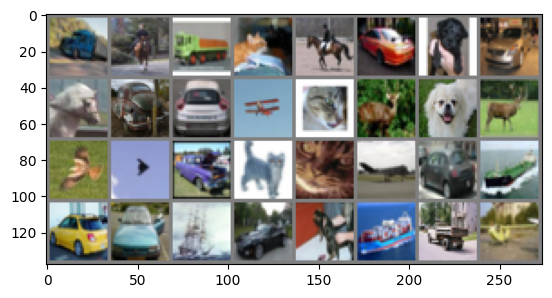

truck horse truck cat


In [6]:
# function to show an image

def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(classes[labels[j]] for j in range(batch_size)))

# Initializing the model

Key nn components in torch:

- `torch.Tensor` - A multi-dimensional array with support for autograd operations like backward(). Also holds the gradient w.r.t. the tensor.
- `torch.nn.Sequential` - A pytorch module which gives us a convinient way to build networks like this where a tensor is passed sequentially through operations.
- `torch.nn.Linear` - A neural net layer for linear transformation.
- `torch.nn.Conv2d` - A layer which applies a 2D convolution over an input signal composed of several input planes.
- `torch.nn.MaxPool2d` - A layer which applies a 2D max pooling over an input signal composed of several input planes.
- `torch.nn.ReLU` - A non linear activation layer which applies the rectified linear unit function element-wise.


In [7]:
import torch.nn as nn

In [75]:
# hyperparameters
input_channel = 3
kernel_size = 5
output_size = 10
pooling_size = 2

hidden_sizes = [128, 64]
conv_sizes = [6, 16]

# model
model = nn.Sequential(
    nn.Conv2d(input_channel, conv_sizes[0], kernel_size),
    nn.ReLU(),
    nn.MaxPool2d(pooling_size),
    
    nn.Conv2d(conv_sizes[0], conv_sizes[1], kernel_size),
    nn.ReLU(),
    nn.MaxPool2d(pooling_size),
    
    nn.Flatten(),
    
    nn.Linear(16 * 5 * 5, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size)
)

# Loss function and optimizer

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.


There are several different loss functions under the nn package . Example of a simple loss is: nn.MSELoss which computes the mean-squared error between the input and the target.

Here we are using CrossEntropyLoss
Optimizers require the parameters to optimize and a learning rate

In [9]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

# Train the model

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [76]:
epochs = 3

def train(epoch,criterion=criterion,optimizer=optimizer):
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 250 == 249:    # print every 2000 mini-batches
#                 print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

train(epochs)
print('Finished Training')

Finished Training


In [68]:
# Task 2: Try 2 different loss functions and report results
# Task 3: Try 2 different optimizers and report results
criterions  = [ nn.MultiMarginLoss(), nn.CrossEntropyLoss()]
optimizers =  [optim.Adam(model.parameters(),lr=0.001), optim.RMSprop(model.parameters(),lr=0.001)]

for criterion in criterions:
    for name, optimizer in zip(["Adam","RMSprop"],optimizers):
        train(3,criterion,optimizer)
        correct = 0
        total = 0

        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:

                images, labels = data
                # calculate outputs by running images through the network
                outputs = model(images)

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'criterion:{str(criterion)} optimizer:{name} accuracy: {100 * correct / total}')

criterion:MultiMarginLoss() optimizer:Adam accuracy: 59.91
criterion:MultiMarginLoss() optimizer:RMSprop accuracy: 60.15
criterion:CrossEntropyLoss() optimizer:Adam accuracy: 60.03
criterion:CrossEntropyLoss() optimizer:RMSprop accuracy: 58.82


Going with CrossEntropy and Adam optimizer as default model

In [72]:
# Task 4: Try different hyperparameters and improve the accuracy
lr = 0.1
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=lr)
train(3)

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:

        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'criterion:{str(criterion)} optimizer:{name} accuracy: {100 * correct / total}')


criterion:CrossEntropyLoss() optimizer:RMSprop accuracy: 58.7925


In [27]:
# save the model
PATH = './cifar_net_crossentropy_loss.pth'
torch.save(model.state_dict(), PATH)

## Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

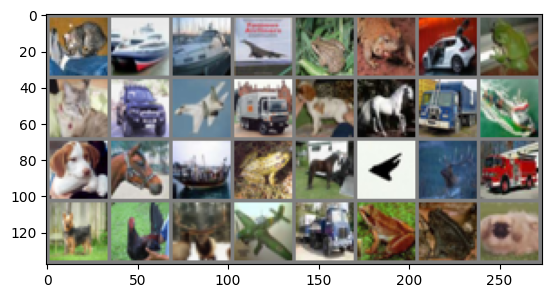

GroundTruth:    cat  ship  ship plane


In [32]:
# Loading the test data 
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [33]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [34]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 51.7 %
Accuracy for class car   is: 70.1 %
Accuracy for class bird  is: 36.8 %
Accuracy for class cat   is: 23.2 %
Accuracy for class deer  is: 36.5 %
Accuracy for class dog   is: 40.3 %
Accuracy for class frog  is: 59.4 %
Accuracy for class horse is: 58.7 %
Accuracy for class ship  is: 56.9 %
Accuracy for class truck is: 49.5 %


In [35]:
# Task 5: Visualize these results in form of histograms
classname, correct_count in correct_pred.items()

{'plane': 517,
 'car': 701,
 'bird': 368,
 'cat': 232,
 'deer': 365,
 'dog': 403,
 'frog': 594,
 'horse': 587,
 'ship': 569,
 'truck': 495}

<BarContainer object of 10 artists>

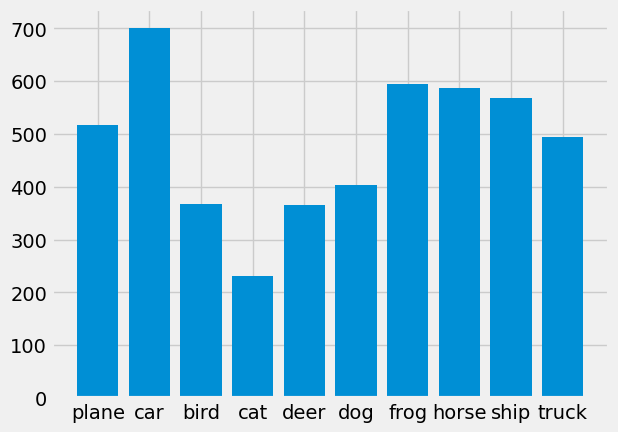

In [50]:
plt.style.use("fivethirtyeight")
plt.bar(correct_pred.keys(),correct_pred.values())
